In [5]:
import pandas as pd
import numpy as np
import pricey as pr
from prophet import Prophet
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import FinanceDataReader as fdr
from sklearn.decomposition import PCA, KernelPCA, FastICA
from sklearn.metrics import silhouette_score
from tqdm.notebook import tqdm
import statsmodels.api as sm
import itertools
from IPython.core.debugger import set_trace
import seaborn as sns
import arviz as az

from sklearnex import patch_sklearn
patch_sklearn()

# import warnings
# warnings.filterwarnings(action='ignore')

import logging
logging.getLogger('prophet').setLevel(logging.WARNING)
logging.getLogger("cmdstanpy").disabled=True

from sklearn.decomposition import PCA, KernelPCA, FastICA
from sklearn.preprocessing import StandardScaler, MinMaxScaler#, Imputer
from sklearn.cluster import KMeans, DBSCAN

%matplotlib inline

import pymc as pm
import aesara as asr

az.style.use("arviz-darkgrid")

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [6]:
# import matplotlib.pyplot as plt
 
# # 한글 폰트 사용을 위해서 세팅
# from matplotlib import font_manager, rc
# font_path = "C:/Windows/Fonts/NGULIM.TTF"
# font = font_manager.FontProperties(fname=font_path).get_name()
# rc('font', family=font)

In [7]:
univ = pd.read_excel('ticker_map.xlsx', converters={'code':str})
univ = list(univ['code']); univ

['005930',
 '005935',
 '000660',
 '006400',
 '006405',
 '051910',
 '051915',
 '005380',
 '005385',
 '035420',
 '068270',
 '000270',
 '035720',
 '105560',
 '005490',
 '055550',
 '207940',
 '012330',
 '373220',
 '028260',
 '086790',
 '033780',
 '066570',
 '066575',
 '096770',
 '316140',
 '017670',
 '034730',
 '003550',
 '030200',
 '009150',
 '259960',
 '036570',
 '323410',
 '000810',
 '009830',
 '015760',
 '032830',
 '051900',
 '010130',
 '011200',
 '003490',
 '034020',
 '003670',
 '011070',
 '018260',
 '402340',
 '028050',
 '009540',
 '010950',
 '010140',
 '352820',
 '047810',
 '097950',
 '090430',
 '034220',
 '021240',
 '000100',
 '035250',
 '086280',
 '032640',
 '251270',
 '000720',
 '011170',
 '267250',
 '004020',
 '024110',
 '161390',
 '377300',
 '010620',
 '005830',
 '011780',
 '008770',
 '383220',
 '271560',
 '006800',
 '329180',
 '071050',
 '012450',
 '018880',
 '078930',
 '016360',
 '011790',
 '001450',
 '139480',
 '010060',
 '128940',
 '138930',
 '004170',
 '030000',
 '302440',

In [8]:
_dflist = [fdr.DataReader(code, '2019-01-01', '2023-03-31') for code in tqdm(univ)]

  0%|          | 0/147 [00:00<?, ?it/s]

In [9]:
p = pd.concat([_s['Close'] for _s in _dflist], axis=1)
p.columns = univ
logp = np.log(p); logp.head()

,005930,005935,000660,006400,006405,051910,051915,005380,005385,035420,...,006650,192820,003850,105630,069500,232080,261220,132030,261240,148070
Date,,,,,,,,,,,,,,,,,,,,,
2019-01-02,10.564886,10.360912,11.012050,12.257241,11.359774,12.727838,12.162643,11.643954,11.136048,11.678440,...,11.901583,11.716111,8.930230,9.888374,10.089386,9.335209,9.684398,9.148465,9.170560,11.653661
2019-01-03,10.534759,10.335270,10.963012,12.220961,11.326596,12.700769,12.136187,11.665647,11.153389,11.711776,...,11.845820,11.704033,8.909100,9.849559,10.079623,9.311813,9.697693,9.152711,9.178850,11.653991
2019-01-04,10.530762,10.323841,10.973357,12.211060,11.304671,12.708362,12.122691,11.691072,11.161949,11.740061,...,11.820410,11.724077,8.916238,9.880731,10.087225,9.330343,9.736547,9.154828,9.176266,11.651600
2019-01-07,10.564886,10.376611,10.980195,12.287653,11.357441,12.745486,12.154779,11.699405,11.159104,11.786762,...,11.904968,11.739822,8.930230,9.935471,10.101313,9.337678,9.764800,9.151121,9.170039,11.652009
2019-01-08,10.547970,10.338511,10.988677,12.294541,11.363265,12.764259,12.173033,11.691072,11.154821,11.775290,...,11.877569,11.739822,8.924124,9.987369,10.094934,9.325542,9.760194,9.146335,9.174195,11.650773


In [10]:
p_open = pd.concat([_s['Open'] for _s in _dflist], axis=1)
p_open.columns = univ; p_open.head()

,005930,005935,000660,006400,006405,051910,051915,005380,005385,035420,...,006650,192820,003850,105630,069500,232080,261220,132030,261240,148070
Date,,,,,,,,,,,,,,,,,,,,,
2019-01-02,39400,32700,61300,222000,87000,351000,195500,117500,70200,121000,...,153500,129881,7518,19600,24544,11672,16420,9345,9555,115125
2019-01-03,38300,31450,60200,209000,85100,337500,193500,113000,69800,120000,...,147500,123019,7518,19600,24073,11378,16330,9400,9670,115125
2019-01-04,37450,30400,57500,201500,82700,327500,182500,116000,69200,123500,...,139000,121059,7390,19150,23834,11080,16705,9450,9670,115187
2019-01-07,38000,30800,59000,209000,83200,340000,186000,121000,71200,128000,...,141000,125470,7593,19900,24330,11408,17315,9380,9600,115396
2019-01-08,38000,31500,57900,218000,86100,346500,190000,121500,70800,132000,...,148000,127430,7593,20650,24381,11348,17420,9405,9605,114840


In [220]:
stock1_name, stock2_name = '066570', '066575'
# stock1_name, stock2_name = '005930', '005935'
# orig_data = logp.loc[:,[stock1_name, stock2_name]]
orig_data = logp.loc['2020-01-01':,[stock1_name, stock2_name]]
data = orig_data.diff().cumsum()
data1 = data[stock1_name].ffill().fillna(0).values
data2 = data[stock2_name].ffill().fillna(0).values

In [221]:
#p_data = p.loc[:,[stock1_name, stock2_name]]
#p_open_data = p_open.loc[:,[stock1_name, stock2_name]]
p_data = p.loc['2020-01-01':,[stock1_name, stock2_name]]
p_open_data = p_open.loc['2020-01-01':,[stock1_name, stock2_name]]

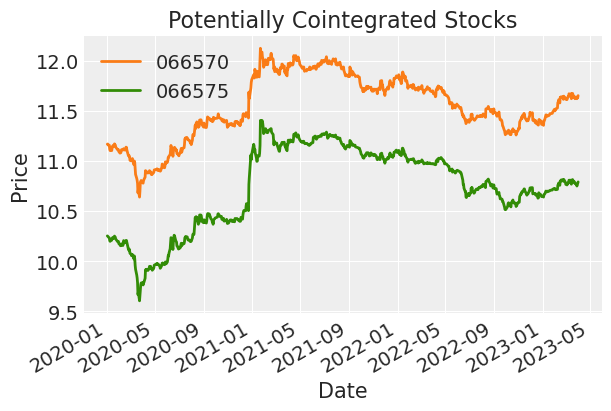

In [222]:
plt.figure(figsize = (6,4))
ax = plt.gca()
plt.title("Potentially Cointegrated Stocks")
orig_data[stock1_name].plot(ax=ax,color=sns.color_palette()[1],linewidth=2)
orig_data[stock2_name].plot(ax=ax,color=sns.color_palette()[2],linewidth=2)
plt.ylabel("Price")
plt.legend()
plt.show()

<Axes: xlabel='Date'>

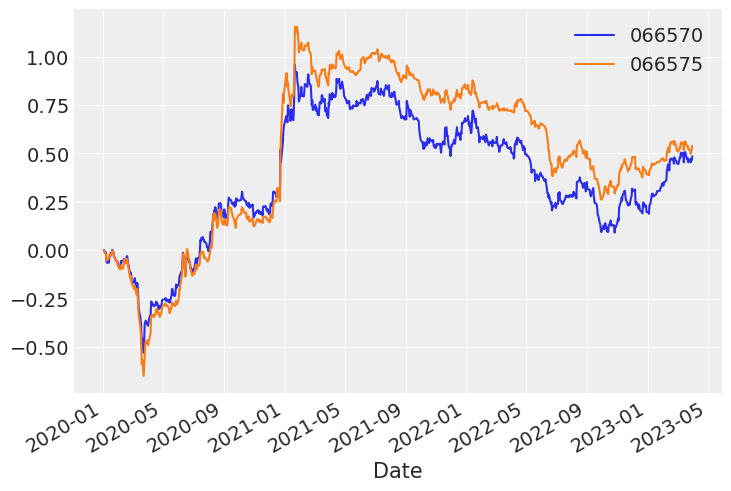

In [223]:
data[[stock1_name, stock2_name]].plot()

In [224]:
data.shape

(804, 2)

In [225]:
with pm.Model() as model:
    
    # inject external stock data
    #stock1 = asr.shared(data1)
    #stock2 = asr.shared(data2)
    stock1 = data1
    stock2 = data2
    
    # define our cointegration variables
    beta_sigma = pm.Exponential('beta_sigma', 50.)
    beta = pm.GaussianRandomWalk('beta', sigma=beta_sigma, shape=data1.shape[0])
    
    # with our assumptions, cointegration can be reframed as a regression problem
    stock2_regression = beta * stock1
    
    # Assume prices are Normally distributed, the mean comes from the regression.
    sd = pm.HalfNormal('sd', sigma=.1)
    likelihood = pm.Normal('y', mu=stock2_regression, sigma=sd, observed=stock2)

with model:
    #stock1.set_value(data1)
    #stock2.set_value(data2)
    #trace = pm.sample(2000,tune=1000,cores=4)
    idata = pm.sample(chains=2, cores=8)

/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/distributions/timeseries.py:301: UserWarning: Initial distribution not specified, defaulting to `Normal.dist(0, 100)`.You can specify an init_dist manually to suppress this warning.
  warnings.warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 8 jobs)
NUTS: [beta_sigma, beta, sd]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 24 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


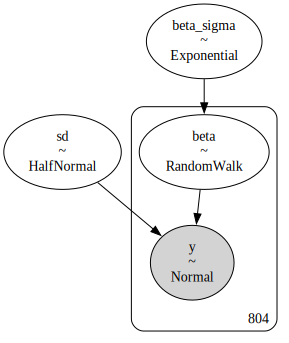

In [18]:
pm.model_to_graphviz(model)

In [226]:
rolling_beta = idata.posterior['beta'].T.mean(axis=1)[:,0]#.mean(axis=1)

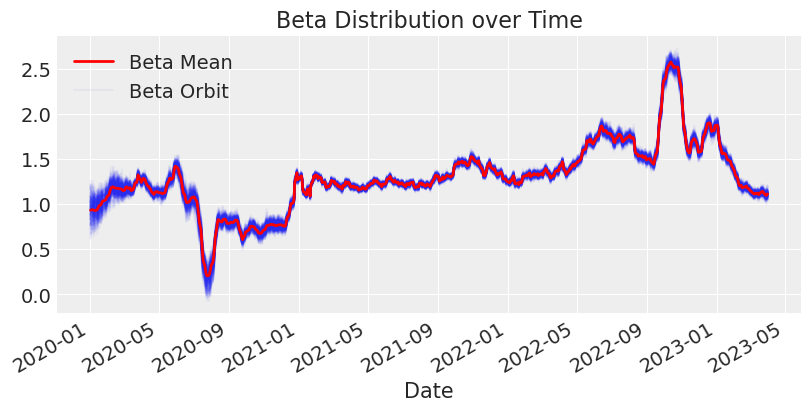

In [20]:
plt.figure(figsize = (8,4))
ax = plt.gca()
plt.title("Beta Distribution over Time")
pd.Series(rolling_beta,index=orig_data.index).plot(ax=ax,color='r',zorder=1e6,linewidth=2)

for orbit in idata.posterior['beta'].sel(draw=slice(0,200))[0]:
    pd.Series(orbit,index=orig_data.index).plot(ax=ax,color=sns.color_palette()[0],alpha=0.05)
    

plt.legend(['Beta Mean','Beta Orbit'])
plt.show()

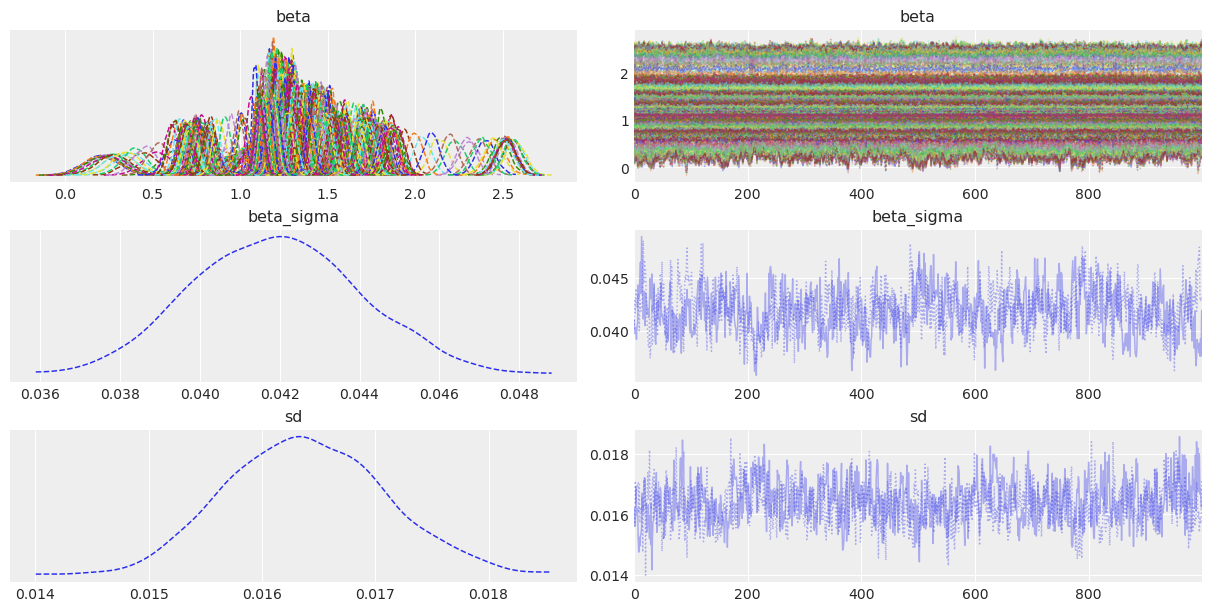

In [21]:
az.plot_trace(idata, combined=True);

In [213]:
def getStrategyPortfolioWeights_old(rolling_beta, stock_name1, stock_name2, data, smoothing_window=15):
    data1 = data[stock_name1].ffill().fillna(0).values
    data2 = data[stock_name2].ffill().fillna(0).values

    # initial signal rebalance
    #fixed_beta = float(rolling_beta[smoothing_window])
    #signal = fixed_beta*data1 - data2
    #smoothed_signal = pd.Series(signal).rolling(smoothing_window).mean()
    #d_smoothed_signal = smoothed_signal.diff()
    trading = "not"
    trading_start = 0
    leverage = 0*data.copy()
    
    for i in range(smoothing_window, data1.shape[0]):
        leverage.iloc[i,:] = leverage.iloc[i-1,:]

        if trading=="not":
            # dynamically rebalance the signal when not trading
            fixed_beta = float(rolling_beta[i])
            signal = fixed_beta*data1 - data2
            smoothed_signal = pd.Series(signal).rolling(smoothing_window).mean()
            d_smoothed_signal = smoothed_signal.diff()

            if smoothed_signal[i] > 0 and d_smoothed_signal[i] < 0:
                leverage.iloc[i,0] = -fixed_beta / (abs(fixed_beta)+1)
                leverage.iloc[i,1] = 1 / (abs(fixed_beta)+1)
                trading = "short"
                trading_start = smoothed_signal[i]
                

#             elif smoothed_signal[i] < 0 and d_smoothed_signal[i] > 0:
#                 #fixed_beta = float(rolling_beta[i])
#                 leverage.iloc[i,0] = fixed_beta / (abs(fixed_beta)+1)
#                 leverage.iloc[i,1] = -1 / (abs(fixed_beta)+1)
#                 trading = "long"
#                 trading_start = smoothed_signal[i]

            else:
                leverage.iloc[i,0] = 0
                leverage.iloc[i,1] = 0

        elif trading=="long":
            # a failed trade
            if smoothed_signal[i] < trading_start:
                leverage.iloc[i,0] = 0
                leverage.iloc[i,1] = 0
                trading = "not"

            # a successful trade
            if smoothed_signal[i] > 0:
                leverage.iloc[i,0] = 0
                leverage.iloc[i,1] = 0
                trading = "not"

        elif trading=="short":
            # a failed trade
            if smoothed_signal[i] > trading_start:
                leverage.iloc[i,0] = 0
                leverage.iloc[i,1] = 0
                trading = "not"

            # a successful trade
            if smoothed_signal[i] < 0:
                leverage.iloc[i,0] = 0
                leverage.iloc[i,1] = 0
                trading = "not"
                
    return leverage

In [214]:
def getStrategyPortfolioWeights(rolling_beta, stock_name1, stock_name2, data, smoothing_window=15):
    data1 = data[stock_name1].ffill().fillna(0).values
    data2 = data[stock_name2].ffill().fillna(0).values

    # initial signal rebalance
    #fixed_beta = float(rolling_beta[smoothing_window])
    #signal = fixed_beta*data1 - data2
    #smoothed_signal = pd.Series(signal).rolling(smoothing_window).mean()
    #d_smoothed_signal = smoothed_signal.diff()
    trading = "not"
    trading_start = 0
    leverage = 0*data.copy()
    
    for i in range(smoothing_window, data1.shape[0]):
        leverage.iloc[i,:] = leverage.iloc[i-1,:]

        if trading=="not":
            # dynamically rebalance the signal when not trading
            fixed_beta = float(rolling_beta[i])
            signal = fixed_beta*data1 - data2
            smoothed_signal = pd.Series(signal).rolling(smoothing_window).mean()
            d_smoothed_signal = smoothed_signal.diff()

            if smoothed_signal[i] > 0 and d_smoothed_signal[i] < 0:
                #leverage.iloc[i,0] = -fixed_beta / (abs(fixed_beta)+1)
                #leverage.iloc[i,1] = 1 / (abs(fixed_beta)+1)
                
                w0 = -fixed_beta / (abs(fixed_beta)+1)
                w1 = 1 / (abs(fixed_beta)+1)
                
                w_max = max(abs(w0), abs(w1))
                
                leverage.iloc[i,0] = w0 / w_max
                leverage.iloc[i,1] = w1 / w_max
                
                trading = "short"
                trading_start = smoothed_signal[i]
                
            else:
                leverage.iloc[i,0] = 0
                leverage.iloc[i,1] = 0

        elif trading=="short":
            # a failed trade
            if smoothed_signal[i] > trading_start:
                leverage.iloc[i,0] = 0
                leverage.iloc[i,1] = 0
                trading = "not"

            # a successful trade
            if smoothed_signal[i] < 0:
                leverage.iloc[i,0] = 0
                leverage.iloc[i,1] = 0
                trading = "not"
                
    return leverage

In [215]:
def backtest_old(pricingDF, leverageDF, start_cash):
    """Backtests pricing based on some given set of leverage. Leverage works such that it happens "overnight",
    so leverage for "today" is applied to yesterday's close price. This algo can handle NaNs in pricing data
    before a stock exists, but ffill() should be used for NaNs that occur after the stock has existed, even
    if that stock ceases to exist later."""
    
    pricing = pricingDF.values
    leverage = leverageDF.values
    
    shares = np.zeros_like(pricing)
    cash = np.zeros(pricing.shape[0])
    cash[0] = start_cash
    curr_price = np.zeros(pricing.shape[1])
    curr_price_div = np.zeros(pricing.shape[1])
    
    for t in range(1, pricing.shape[0]):
        
        #set_trace()
        if np.any(leverage[t] != leverage[t-1]):
            # handle non-existent stock values
            curr_price[:] = pricing[t-1]     # you can multiply with this one
            curr_price[np.isnan(curr_price)] = 0
            trading_allowed = (curr_price!=0)
            curr_price_div[:] = curr_price    # you can divide with this one
            curr_price_div[~trading_allowed] = 1
            
            # determine new positions (warning: leverage to non-trading_allowed stocks is just lost)
            portfolio_value = (shares[t-1] * curr_price).sum() + cash[t-1]
            target_shares = trading_allowed * (portfolio_value*leverage[t]) // curr_price_div
            
            # rebalance
            shares[t] = target_shares
            cash[t] = cash[t-1] - ((shares[t]-shares[t-1])*curr_price).sum()
            # set_trace()
            
        else:
            
            # maintain positions
            shares[t] = shares[t-1]
            cash[t] = cash[t-1]
    
    returns = (shares*np.nan_to_num(pricing)).sum(axis=1)+cash
    pct_returns = (returns-start_cash) / start_cash
    
    return (
        pd.DataFrame(shares, index=pricingDF.index, columns=pricingDF.columns),
        pd.Series(cash, index=pricingDF.index),
        pd.Series(pct_returns, index=pricingDF.index)
    )

In [216]:
def backtest(pricingDF, openDF, leverageDF, start_cash):
    pricing = pricingDF.values
    pricing_open = openDF.values
    leverage = leverageDF.values
    
    shares = np.zeros_like(pricing)
    cash = np.zeros(pricing.shape[0])
    cash[0] = cash[1] = start_cash
    curr_price = np.zeros(pricing.shape[1])
    
    total_cost = 0
    pnl_hist = np.zeros(pricing.shape[0])
    pnl = []
    values = np.zeros(pricing.shape[0])
    values[0] = values[1] = start_cash

    
    for t in range(2, pricing.shape[0]):
        if np.any(leverage[t-1] != leverage[t-2]):
            target_shares = (start_cash * leverage[t-1] / pricing[t-1]).astype(int)
            
            # rebalance
            shares[t] = target_shares
            cost0 = abs(shares[t,0] - shares[t-1,0]) * pricing_open[t,0] * 0.0001
            cost1 = abs(shares[t,1] - shares[t-1,1]) * pricing_open[t,1] * (0.00025 if shares[t,1] > shares[t-1,1] else 0.00225)

            cash[t] = cash[t-1] - ((shares[t]-shares[t-1]) * pricing_open[t]).sum() - cost0 - cost1
            total_cost += (cost0 + cost1)
            #set_trace()
            
        else:
            # maintain positions
            shares[t] = shares[t-1]
            cash[t] = cash[t-1]
            
        values[t] = (shares[t] * pricing[t]).sum() + cash[t]
            
        if shares[t-1,0]==0 and shares[t,0]!=0:
            pnl_hist[t] = values[t] - values[t-1]
            
        elif shares[t,0]!=0 or (shares[t-1,0]!=0 and shares[t,0]==0):
            pnl_hist[t] = pnl_hist[t-1] + values[t] - values[t-1]
            
        if shares[t-1,0]!=0 and shares[t,0]==0:
            pnl.append(pnl_hist[t])
    
    
    pct_returns = (values - start_cash) / start_cash
    
    n_days = pct_returns.shape[0]
    total_profit = int(values[-1] - start_cash)
    total_return = pct_returns[-1] * 100
    total_cost_rate = total_cost / total_profit * 100
    n_entry = len(pnl)
    n_entry_monthly = n_entry / n_days * 20
    n_entry_days = (portfolioWeights.iloc[:,0] != 0).sum()
    n_holding_days = n_entry_days / n_entry
    pnl_by_entry = total_profit / n_entry
    profit_of_profit_entry = np.mean(list(filter(lambda x: x>0, pnl)))
    loss_of_loss_entry = np.mean(list(filter(lambda x: x<0, pnl)))

    print(f'테스트 일수: {n_days}일')
    print(f'총손익 (투자금액대비%): {format(total_profit, ",")}원 ({total_return:.3f}%)')
    print(f'총비용 (총손익대비%): {format(int(total_cost), ",")}원 ({total_cost_rate:.3f}%)')
    print(f'진입횟수: {n_entry}회')
    print(f'월평균 진입횟수: {n_entry_monthly:.2f}회')
    print(f'진입일수 (전체일수대비%): {n_entry_days}일 ({n_entry_days/n_days*100:.2f}%)')
    print(f'평균보유일수: {n_holding_days:.2f}일')
    print(f'진입당 평균손익: {format(int(pnl_by_entry), ",")}원')
    print(f'최대수익: {format(int(max(pnl)), ",")}원')
    print(f'최대손실: {format(int(min(pnl)), ",")}원')
    print(f'수익진입의 평균수익: {format(int(profit_of_profit_entry), ",")}원')
    print(f'손실진입의 평균손실: {format(int(loss_of_loss_entry), ",")}원')
    
    return (
        pd.DataFrame(shares, index=pricingDF.index, columns=pricingDF.columns),
        pd.Series(cash, index=pricingDF.index),
        pd.Series(pct_returns, index=pricingDF.index),
        pd.Series(values, index=pricingDF.index),
        pd.Series(pnl_hist, index=pricingDF.index),
        pd.Series(pnl)
    )

<Axes: xlabel='Date'>

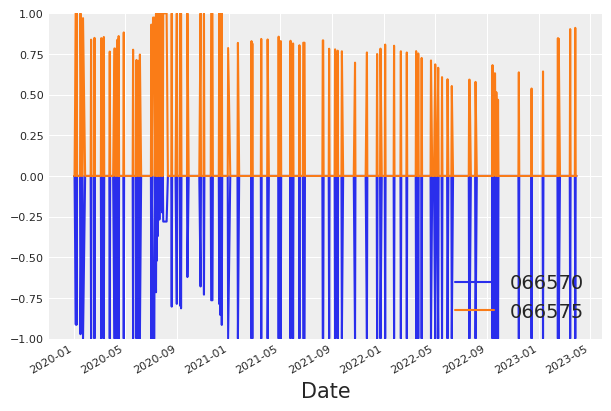

In [227]:
portfolioWeights = getStrategyPortfolioWeights(rolling_beta, stock1_name, stock2_name, data, smoothing_window=1).fillna(0)
portfolioWeights.plot(figsize=(6,4), ylim=(-1,1), fontsize=8)

<Axes: xlabel='Date'>

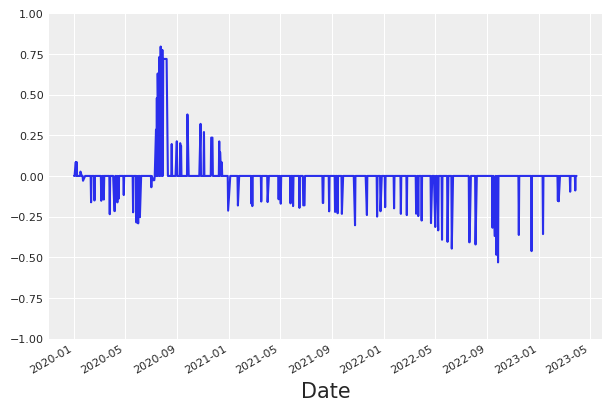

In [228]:
portfolioWeights.sum(axis=1).plot(figsize=(6,4), ylim=(-1,1), fontsize=8)

테스트 일수: 804일
총손익 (투자금액대비%): 53,803,956원 (53.804%)
총비용 (총손익대비%): 18,814,543원 (34.969%)
진입횟수: 84회
월평균 진입횟수: 2.09회
진입일수 (전체일수대비%): 98일 (12.19%)
평균보유일수: 1.17일
진입당 평균손익: 640,523원
최대수익: 24,312,212원
최대손실: -4,411,055원
수익진입의 평균수익: 1,543,867원
손실진입의 평균손실: -1,072,715원


<Axes: xlabel='Date'>

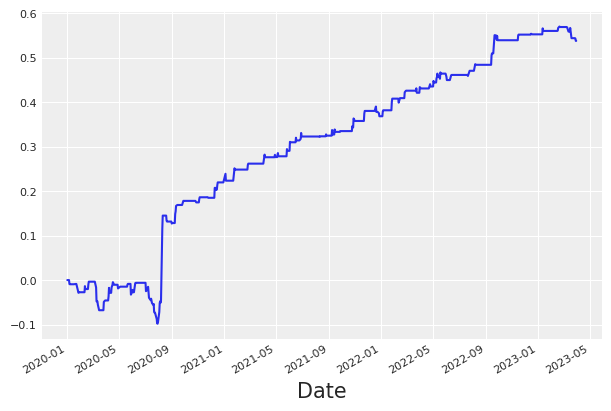

In [210]:
shares, cash, returns, values, pnl_hist, pnl = backtest(p_data, p_open_data, portfolioWeights, 1e8)
returns.plot(figsize=(6,4), fontsize=8)

테스트 일수: 804일
총손익 (투자금액대비%): 55,266,616원 (55.267%)
총비용 (총손익대비%): 18,958,933원 (34.304%)
진입횟수: 84회
월평균 진입횟수: 2.09회
진입일수 (전체일수대비%): 99일 (12.31%)
평균보유일수: 1.18일
진입당 평균손익: 657,935원
최대수익: 24,354,559원
최대손실: -4,416,278원
수익진입의 평균수익: 1,526,273원
손실진입의 평균손실: -1,078,739원


<Axes: xlabel='Date'>

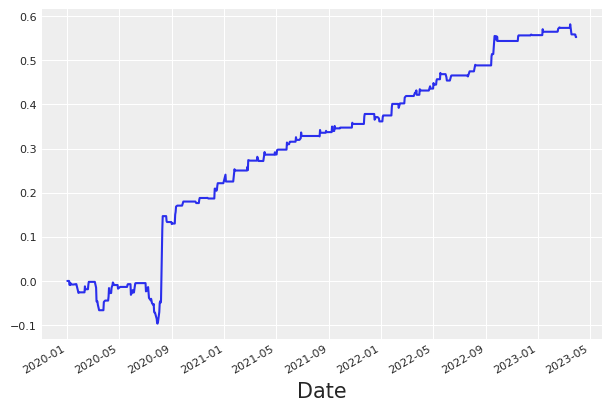

In [229]:
shares, cash, returns, values, pnl_hist, pnl = backtest(p_data, p_open_data, portfolioWeights, 1e8)
returns.plot(figsize=(6,4), fontsize=8)